# Numerical Calculation: Divergence in the Variance of Jarzynski Estimator of QHO



In [1]:
#front matter
import numpy as np
import matplotlib.pyplot as plt
import math

#If your screen has retina display this will increase resolution of plots
%config InlineBackend.figure_format = 'retina'

## Function Defination

### Basic constants

In [2]:
# grid points
N=2000 

# spatial grid
XMin=-50
XMax=50
X=np.linspace(XMin, XMax, N)
dx = X[1] - X[0]

# momentum grid
P=(2*np.pi/(XMax-XMin))*np.concatenate((np.arange(N//2), np.arange(-N//2,0))) 

# simulation points
M = 100                   

# initial and final conditions
w0=0.35
w1=1

# how many states you want to involve
n=30

### Eigen matters

#### Eigen calculation

In [3]:
# potential energy
def potential(x, w):
    return 0.5 * (w * x)**2

# Eigen calculation function
def Eigen(w):
    # define hamiltonian
    V= np.diag(potential(X,w), 0)
    T = np.diag(np.ones(N), 0)/(dx**2) - 0.5 * np.diag(np.ones((N-1)), 1)/(dx**2) - 0.5 * np.diag(np.ones((N-1)), -1)/(dx**2)
    H = T + V
    # calculate eigenvalues
    eigE_0, eigV_0 = np.linalg.eig(H)  
    idx_sorted = np.argsort(eigE_0) 
    eigE, eigV = eigE_0[idx_sorted], eigV_0[:, idx_sorted]
    return eigE,eigV

# Eigen matters for initial and final conditions
Eigen_0=Eigen(w0)
Eigen_1=Eigen(w1)

#### Eigenfunction

In [4]:
# eigenfunction with normalization
def psi(w, v):
    if w==0:
        Psix_0 = Eigen_0[1]
    elif w == 1:
        Psix_0 = Eigen_1[1]
    Psix = Psix_0[:,v]
    normal = np.sqrt(sum(abs(Psix)**2))
    return Psix/normal

In [5]:
print(Eigen_1[0][100])

98.89435404275847


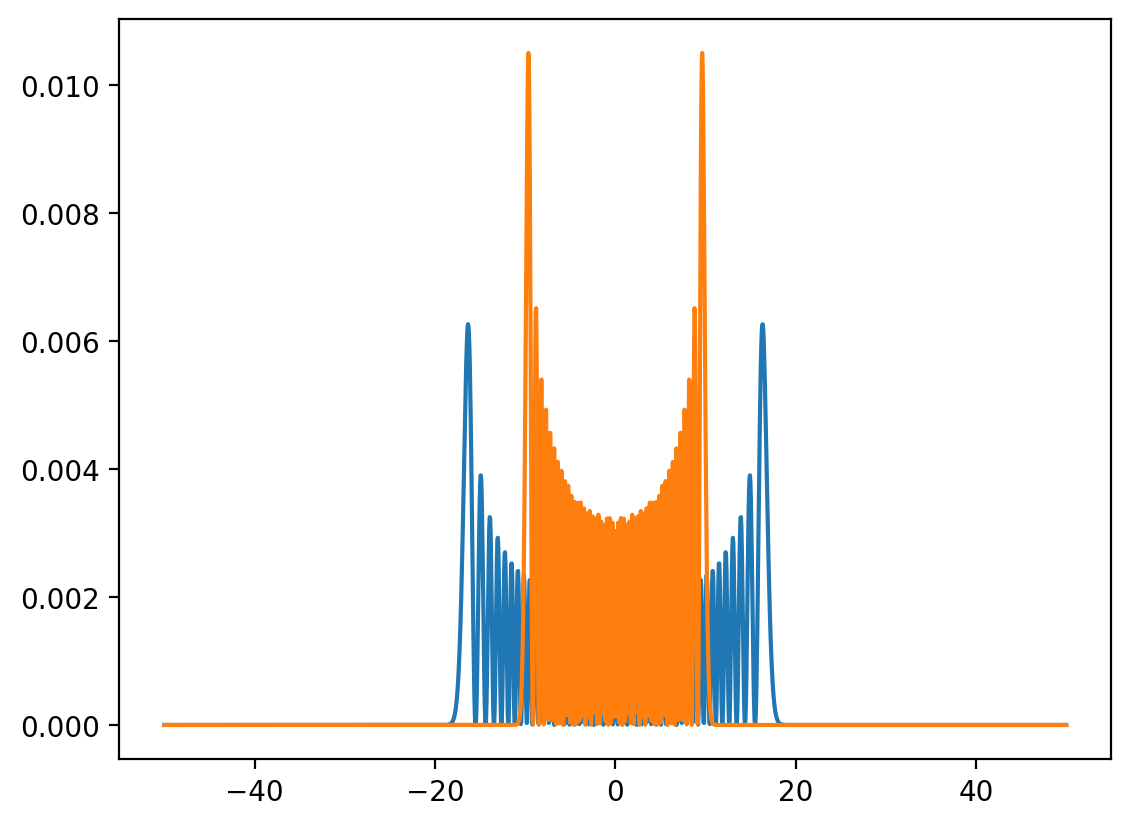

In [6]:
# plot to see an example
plt.plot(X, np.abs(psi(0, 50))**2)  
plt.plot(X, np.abs(psi(1, 50))**2)  

#### Eigenvalue

In [7]:
# Eigenvalues 
def E(w,v):
    if w==0:
        eigE_0 = Eigen_0[0]
    elif w==1:
        eigE_0 = Eigen_1[0]
    eigE = eigE_0[v]
    return eigE

In [8]:
# see an example
print(E(0,1))

0.5249520958280558


### Time operator

In [9]:
def simulation(psi,tau,dt):
    M = int(tau/dt)
    psi_0 = psi.copy()
    for m in range(M):
        Vcase=((w0+((w1-w0)/M)*m)*X)**2/2
        Tcase=P**2/2
        UV = np.exp(-1j*Vcase*dt/2)
        UT = np.exp(-1j*Tcase*dt)  
        psi_1 = UV*psi_0
        phi_2 = np.fft.fft(psi_1)   # wavefunction in momentum space
        phi_3 = UT*phi_2
        psi_3 = np.fft.ifft(phi_3)
        psi_4 = UV*psi_3
        psi_0 = psi_4  # prepare a new cycle
    psi_final = psi_4.copy()
    return psi_final

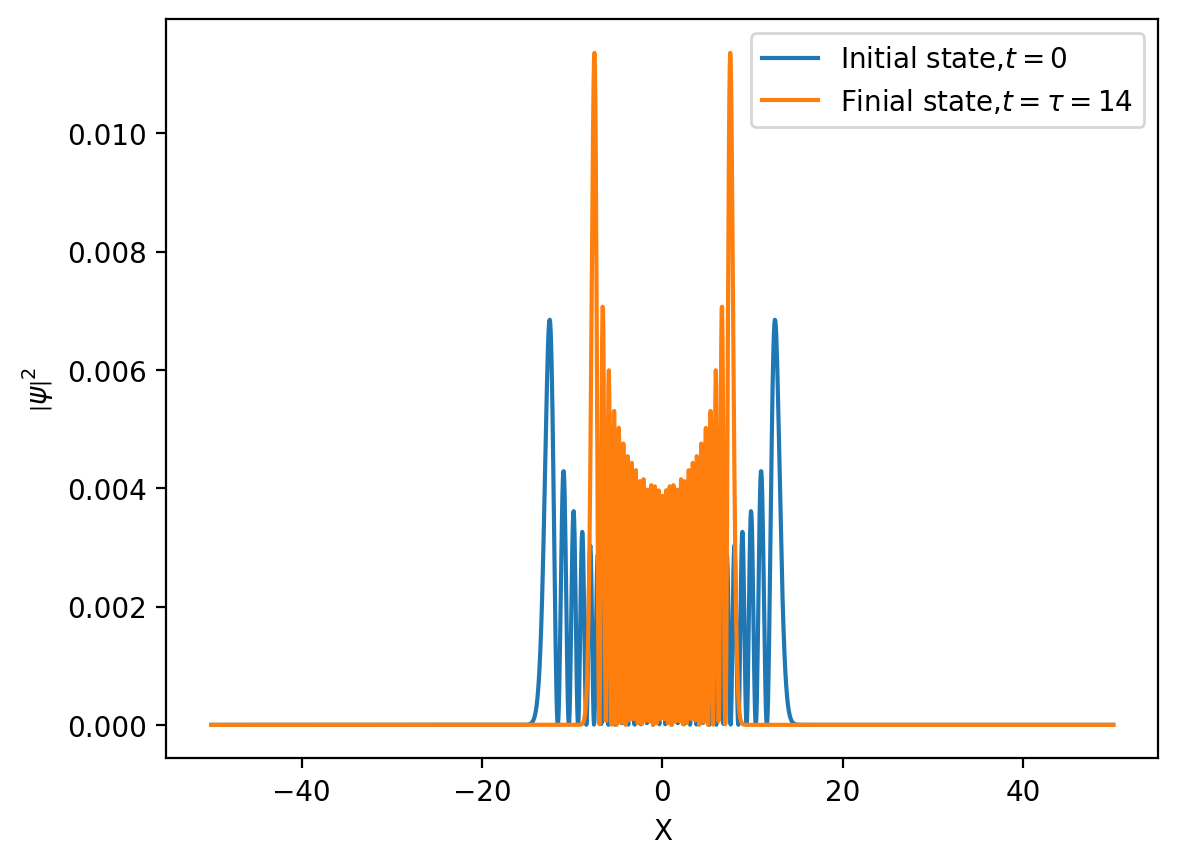

In [10]:
# see an example
plt.plot(X, np.abs(psi(0,n))**2,label='Initial state,$t=0$')  
# plt.plot(X, np.abs(simulation(psi(0,w0),0.5))**2,label='Finial state,$t=\\tau=14$')  # plotting the final state profile
plt.plot(X, np.abs(simulation(psi(0,n),14,0.25))**2,label='Finial state,$t=\\tau=14$')  # plotting the final state profile
plt.xlabel('X')
plt.ylabel('$\\left|\\psi\\right|^2$')
plt.legend()
plt.show()

### Partition function

In [11]:
def Z(w,beta):
    Z_0=0
    for v in range(n):
        energy = E(w,v) 
        Z_0 += np.exp(-beta * energy)  
    return Z_0

In [13]:
print(Z(0,6))

0.39880716527895965


### Helmholtz free energy difference $\Delta F$

In [14]:
def delta_F(beta):
    delta_F_0=1/beta*math.log(Z(0,beta)/Z(1,beta))
    return delta_F_0

## Simulate the variance of Jarzynski Estimator of QHO for different $\hbar \beta$

In [15]:
# beta range
beta_range = np.linspace(0.3, 8, 50)
delta_beta = beta_range[1] - beta_range[0]

Function of $\operatorname{var}\left(e^{-\beta W_{\text {dis }}}\right)=\operatorname{var}\left(e^{-\beta W}\right) / e^{-2 \beta \Delta F}$, with simulation time of $\tau$.

In [16]:
def var_list(tau):
    var_list_0 = []
    for beta in beta_range:
        Z0= Z(0,beta)
        DF= delta_F(beta)
        Fm=0.0
        Sm=0.0
        for i in range(n):
            for j in range(n):
                psi0=psi(0, i)
                psit=simulation(psi0,tau)
                psi1=psi(1, j)
                Fm+=np.exp(-beta*(E(1,j)-E(0,i)))*((abs(np.dot(psi1,psit)))**2)*(np.exp(-beta*E(0,i))/Z0)
                Sm+=np.exp(-beta*(2*E(1,j)-E(0,i)))*((abs(np.dot(psi1,psit)))**2)/Z0
        Var=Sm-Fm**2
        Var_dis=Var/np.exp(-2*beta*DF)
        var_list_0.append(Var_dis)
    return var_list_0

Take $\tau = 1.15$ and $\tau=14$ for an example

In [17]:
var_list_2=var_list(20)

TypeError: simulation() missing 1 required positional argument: 'dt'

In [ ]:
# plt.plot(beta_range, var_list_1, label='$\\tau=1.15$')
plt.plot(beta_range, var_list_2, label='$\\tau=14$')

plt.xlabel(r'$ \beta$')
plt.ylabel(r'$Var(exp(-\beta W_{dis})$')
plt.title('Variance of Jarzynski Estimator of QHO')
plt.ylim(0, 10)
plt.yticks([0,5,10], ['0', '5', '10'])
plt.legend() 

plt.xticks([0, 2, 4, 6, 8], ['0', '2', '4', '6', '8'])
plt.show()